In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

print(tf.__version__)

2.9.1


In [3]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 1200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Tensile Strength, Ultimate]')
  plt.legend()
  plt.grid(True)

<AxesSubplot:>

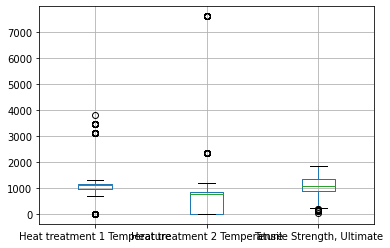

In [4]:
nickel_data = pd.read_csv("dataWithHeat.csv", index_col=0)
nickel_data.boxplot(column=['Heat treatment 1 Temperature', 'Heat treatment 2 Temperature', 'Tensile Strength, Ultimate'])

In [5]:

# For now we must get rid of the data without heat treatments.
# Luckily, this is shown in values with zero heat treatment 1 temp
# nickel_data = nickel_data.drop(
    # nickel_data[nickel_data['Heat treatment 1 Temperature'] < 3].index)

# There seems to be incorrect entries, drop them
# nickel_data = nickel_data.drop(
    # nickel_data[nickel_data['Heat treatment 2 Temperature'] > 7599].index)
# TODO: Check that this is alright
# nickel_data = nickel_data.drop(
    # nickel_data[nickel_data['Tensile Strength, Ultimate'] < 100].index)


# Drop the names column
nickel_data = nickel_data.drop(columns="Name")

nickel_data.head()


,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,989.0,954.0,1.0,788.0,8.0,704.0,8,760.0,500,0,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,NaN,1121.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,NaN,1232.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,NaN,1010.0,4.0,843.0,4.0,760.0,16,0.0,0,0,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train UTS Model

In [6]:
uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
uts_data = uts_data.drop(
    columns=['Tensile Strength, Yield', 'Elongation at Break'])
uts_data = uts_data.fillna(0)
uts_data = uts_data.astype("float32")

uts_train_data = uts_data.sample(frac=0.8, random_state=2212)
uts_test_data = uts_data.drop(uts_train_data.index)

uts_data.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Si,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate"
1,1121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,845.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.95,0.0,0.0,0.0,0.0,0.0,0.0,1261.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.80,0.0,0.0,0.0,0.0,0.0,0.1,870.0
11,1160.0,4.0,1080.0,4.0,850.0,24.0,760.0,16.0,0.0,0.0,...,0.02,0.0,3.45,0.0,0.0,0.0,0.0,0.0,0.0,1466.0
13,1121.0,1.0,843.0,4.0,718.0,8.0,621.0,8.0,0.0,0.0,...,0.06,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,816.0


<AxesSubplot:>

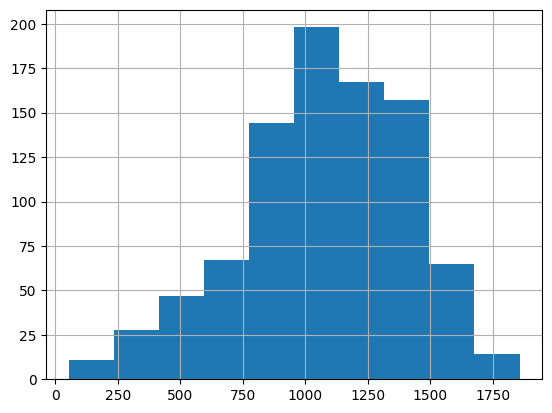

In [7]:
uts_data["Tensile Strength, Ultimate"].hist()

<AxesSubplot:>

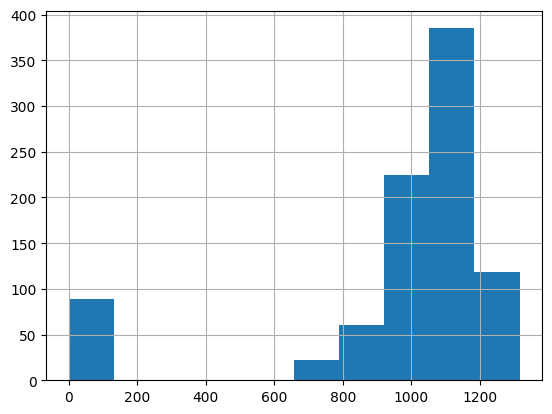

In [8]:
uts_data["Heat treatment 1 Temperature"].hist()

In [9]:
uts_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Heat treatment 1 Temperature,718.0,958.014771,348.008209,0.0,954.444458,1080.000000,1159.2500,1316.000000
Heat treatment 1 Time,718.0,7.935237,26.202442,0.0,1.000000,2.000000,4.0000,172.000000
Heat treatment 2 Temperature,718.0,683.066833,697.668579,0.0,593.000000,760.000000,848.5000,7600.000000
Heat treatment 2 Time,718.0,23.069637,181.768799,0.0,0.000000,4.000000,8.0000,2000.000000
Heat treatment 3 Temperature,718.0,412.826385,388.443878,0.0,0.000000,621.000000,760.0000,1185.000000
Heat treatment 3 Time,718.0,13.532033,67.584267,0.0,0.000000,3.000000,16.0000,760.000000
Heat treatment 4 Temperature,718.0,108.832253,261.184082,0.0,0.000000,0.000000,0.0000,871.000000
Heat treatment 4 Time,718.0,28.696379,199.989243,0.0,0.000000,0.000000,0.0000,1500.000000
Heat treatment 5 Temperature,718.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000
Heat treatment 5 Time,718.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000


In [10]:
uts_train_features = uts_train_data.copy()
uts_test_features = uts_test_data.copy()

uts_train_labels = uts_train_features.pop("Tensile Strength, Ultimate")
uts_test_labels = uts_test_features.pop("Tensile Strength, Ultimate")

In [11]:
uts_normalizer = tf.keras.layers.Normalization(axis=-1)
uts_normalizer.adapt(np.array(uts_train_features))

In [12]:
first = np.array(uts_train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', uts_normalizer(first).numpy())

First example: [[ 954.44    1.    718.33    8.    621.11    8.    648.89 1500.      0.
     0.      1.22    0.      0.06    0.36   17.78    0.     18.87    0.
     0.      0.      0.11    2.93    0.      3.94   53.28    0.      0.
     0.      0.88    0.      0.56    0.      0.      0.      0.      0.
     0.  ]]

Normalized: [[-0.01 -0.26  0.05 -0.08  0.54 -0.08  2.07  7.36  0.    0.   -0.64 -0.45
  -0.1  -1.06  0.49  1.47  1.   -0.04  0.   -0.11  0.16 -0.16 -0.13  1.23
  -0.34 -0.32  0.    0.    4.07 -0.44 -1.04 -0.19 -0.51  0.    0.    0.
  -0.57]]


### First try with a linear model (For sanity)

In [13]:
linear_model = tf.keras.Sequential([
    uts_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 37)               75        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [14]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [15]:
%%time
history = linear_model.fit(
    uts_train_features,
    uts_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

KeyboardInterrupt: 

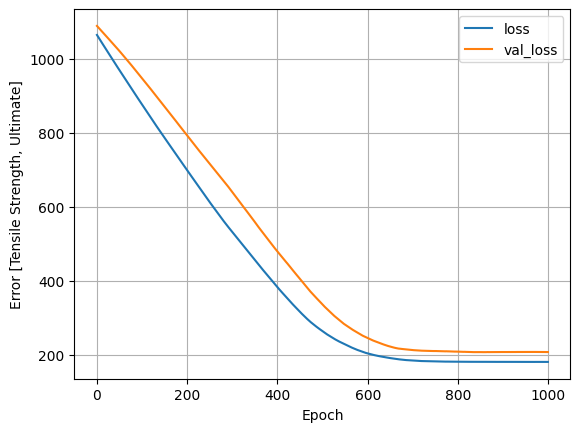

In [ ]:
plot_loss(history)

### Now train a NN model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(50, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(50, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

In [ ]:
dnn_model = build_and_compile_model(uts_normalizer)
dnn_model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_85 (Dense)            (None, 50)                1900      
                                                                 
 dropout_33 (Dropout)        (None, 50)                0         
                                                                 
 dense_86 (Dense)            (None, 50)                2550      
                                                                 
 dropout_34 (Dropout)        (None, 50)                0         
                                                                 
 dense_87 (Dense)            (None, 1)                 51        
                                                     

In [ ]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
%%time
history = dnn_model.fit(
    uts_train_features,
    uts_train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=10000,
    callbacks=es)

Epoch 41: early stopping
CPU times: total: 2.41 s
Wall time: 1.56 s


In [ ]:
dnn_model.evaluate(uts_test_features, uts_test_labels, verbose=0)

189.31515502929688

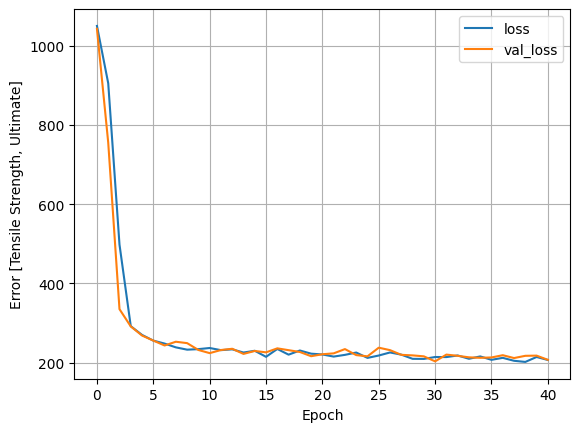

In [ ]:
plot_loss(history)

6/6 [==============================] - 0s 801us/step


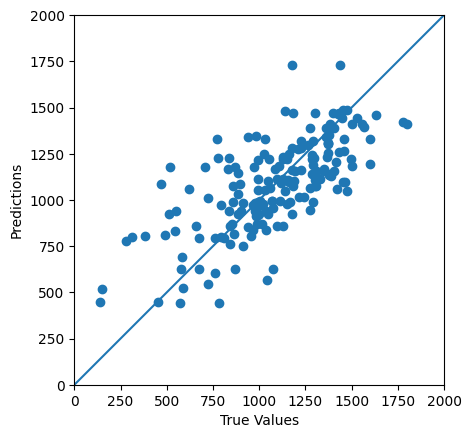

In [ ]:
test_predictions = dnn_model.predict(uts_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(uts_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Train Yield Model

In [ ]:
yield_data = nickel_data.dropna(subset='Tensile Strength, Yield')
yield_data = yield_data.drop(
    columns=["Tensile Strength, Ultimate", 'Elongation at Break'])
yield_data = yield_data.fillna(0)
yield_data = yield_data.astype("float32")

yield_train_data = yield_data.sample(frac=0.8, random_state=1234)
yield_test_data = yield_data.drop(yield_train_data.index)

yield_data.head()

,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,...,Ru,Si,Ta,Ti,V,W,Y,Th,O,Zr
0,989.0,954.0,1.0,788.0,8.0,704.0,8.0,760.0,500.0,0.0,...,0.0,0.0,0.0,0.70,0.00,1.00,0.0,0.0,0.0,0.000
5,1074.0,1149.0,1.0,700.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000
8,1055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.18,0.74,0.00,0.0,0.0,0.0,0.060
12,260.0,1177.0,1.0,816.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.5,0.0,0.00,0.00,2.50,0.0,0.0,0.0,0.000
14,1581.0,1175.0,2.0,760.0,8.0,649.0,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.00,0.00,1.25,0.0,0.0,0.0,0.035


In [ ]:
yield_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Yield",837.0,798.686523,299.457764,55.0,617.000,825.000000,995.000,1654.000000
Heat treatment 1 Temperature,837.0,1090.358154,598.411804,0.0,982.000,1113.000000,1175.000,3812.399902
Heat treatment 1 Time,837.0,4.190084,8.410214,0.0,1.000,2.000000,4.000,50.000000
Heat treatment 2 Temperature,837.0,784.900085,810.652161,0.0,650.000,788.000000,871.000,7600.000000
Heat treatment 2 Time,837.0,19.888889,158.519638,0.0,1.000,4.000000,8.000,2000.000000
Heat treatment 3 Temperature,837.0,427.832031,509.929382,0.0,0.000,0.000000,760.000,2012.400024
Heat treatment 3 Time,837.0,11.252090,61.121338,0.0,0.000,4.000000,16.000,1000.000000
Heat treatment 4 Temperature,837.0,77.696533,222.462051,0.0,0.000,0.000000,0.000,843.000000
Heat treatment 4 Time,837.0,7.579451,54.915379,0.0,0.000,0.000000,0.000,1000.000000
Heat treatment 5 Temperature,837.0,3.632019,52.444530,0.0,0.000,0.000000,0.000,760.000000


In [ ]:
yield_train_features = yield_train_data.copy()
yield_test_features = yield_test_data.copy()

yield_train_labels = yield_train_features.pop('Tensile Strength, Yield')
yield_test_labels = yield_test_features.pop('Tensile Strength, Yield')

yield_train_features.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Ru,Si,Ta,Ti,V,W,Y,Th,O,Zr
2577,1288.0,4.0,1079.0,4.0,871.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.0,1.50,0.0,4.00,0.0,0.0,0.0,0.000
1820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.95,0.0,0.00,0.0,0.0,0.0,0.000
1759,899.0,24.0,1093.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.54,0.0,3.42,0.0,0.0,0.0,0.044
658,1157.0,4.0,1090.0,4.0,845.0,24.0,760.0,16.0,0.0,0.0,...,0.0,0.0,0.0,5.10,0.0,1.19,0.0,0.0,0.0,0.000
2619,982.0,1.0,718.0,8.0,621.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.1,0.0,0.92,0.0,0.00,0.0,0.0,0.0,0.000


In [ ]:
yield_normalizer = tf.keras.layers.Normalization(axis=-1)
yield_normalizer.adapt(np.array(yield_train_features).astype('float32'))


In [ ]:
first = np.array(yield_train_features[:1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', yield_normalizer(first).numpy())

First example: [[1288.     4.  1079.     4.   871.    16.     0.     0.     0.     0.
     5.     0.     0.     5.    10.     0.     0.     0.     0.     0.
     0.     0.     0.     0.    63.     0.     0.     0.     0.    12.
     1.5    0.     4.     0.     0.     0.     0. ]]

Normalized: [[ 0.33 -0.02  0.36 -0.1   0.87  0.08 -0.35 -0.14 -0.07 -0.07  1.37 -0.65
  -1.34 -0.42 -1.27 -0.03 -0.6  -0.29 -0.09 -0.09 -0.38 -1.07 -0.1  -0.73
   0.64 -0.32 -0.06  0.   -0.52  7.01 -0.39 -0.15  1.06 -0.17 -0.06 -0.17
  -0.56]]


### First try with a linear model (For sanity)

In [ ]:
linear_model = tf.keras.Sequential([
    yield_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_24 (Dense)            (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = linear_model.fit(
    yield_train_features,
    yield_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

CPU times: total: 37 s
Wall time: 27.5 s


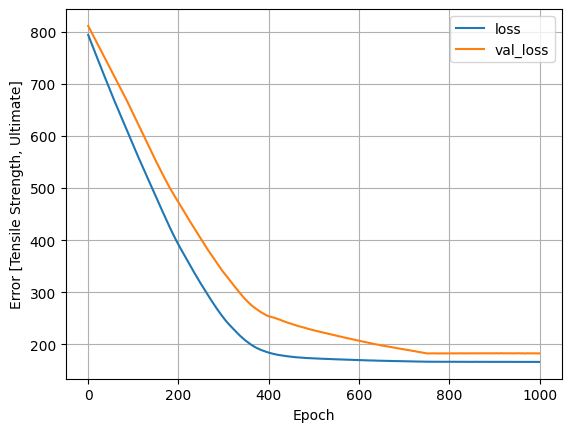

In [ ]:
plot_loss(history)

### Now train a NN model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])
  
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(yield_normalizer)
dnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 25)                950       
                                                                 
 dense_26 (Dense)            (None, 25)                650       
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,626
Non-trainable params: 75
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    yield_train_features,
    yield_train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: total: 51.5 s
Wall time: 30.1 s


In [ ]:
dnn_model.evaluate(yield_test_features, yield_test_labels, verbose=0)

154.2013702392578

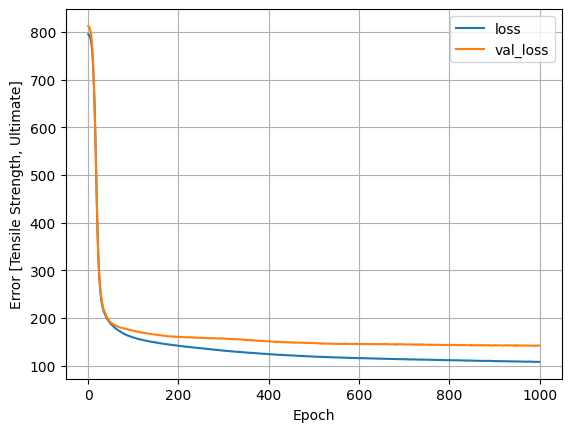

In [ ]:
plot_loss(history)

7/7 [==============================] - 0s 500us/step


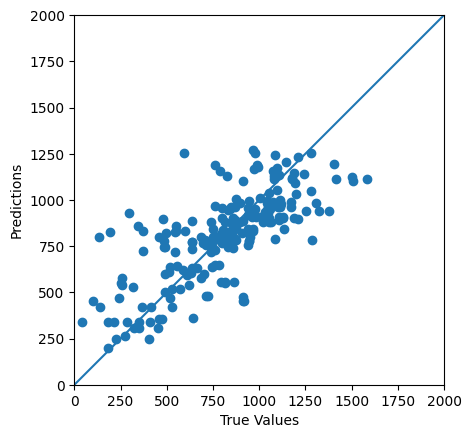

In [ ]:
test_predictions = dnn_model.predict(yield_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(yield_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Train Elongation Model

In [ ]:
elong_data = nickel_data.dropna(subset='Elongation at Break')
elong_data = elong_data.drop(
    columns=["Tensile Strength, Ultimate", 'Tensile Strength, Yield'])
elong_data = elong_data.fillna(0)
elong_data = elong_data.astype("float32")


elong_train_data = elong_data.sample(frac=0.8, random_state=4321)
elong_test_data = elong_data.drop(elong_train_data.index)

elong_data.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Si,Ta,Ti,V,W,Y,Th,O,Zr,Elongation at Break
5,1149.0,1.0,700.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000,26.400000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,4.18,0.74,0.00,0.0,0.0,0.0,0.060,22.700001
12,1177.0,1.0,816.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.0,0.00,0.00,2.50,0.0,0.0,0.0,0.000,30.000000
14,1175.0,2.0,760.0,8.0,649.0,24.0,0.0,0.0,0.0,0.0,...,0.00,0.0,5.00,0.00,1.25,0.0,0.0,0.0,0.035,17.299999
16,982.0,1.0,622.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.07,0.0,0.27,0.00,0.00,0.0,0.0,0.0,0.000,47.000000


In [ ]:
elong_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Heat treatment 1 Temperature,718.0,1085.780518,639.165588,0.0,982.00,1100.000000,1160.000000,3812.399902
Heat treatment 1 Time,718.0,4.273398,8.679023,0.0,1.00,2.000000,4.000000,50.000000
Heat treatment 2 Temperature,718.0,765.327271,873.934998,0.0,0.00,760.000000,871.000000,7600.000000
Heat treatment 2 Time,718.0,26.398329,190.739868,0.0,1.00,4.000000,8.000000,2000.000000
Heat treatment 3 Temperature,718.0,423.435944,526.454529,0.0,0.00,0.000000,757.500000,2012.400024
Heat treatment 3 Time,718.0,12.110028,65.976265,0.0,0.00,1.000000,16.000000,1000.000000
Heat treatment 4 Temperature,718.0,70.892761,210.564758,0.0,0.00,0.000000,0.000000,843.000000
Heat treatment 4 Time,718.0,2.696379,37.509567,0.0,0.00,0.000000,0.000000,1000.000000
Heat treatment 5 Temperature,718.0,5.292479,63.244324,0.0,0.00,0.000000,0.000000,760.000000
Heat treatment 5 Time,718.0,0.055710,0.665730,0.0,0.00,0.000000,0.000000,8.000000


In [ ]:
elong_train_features = elong_train_data.copy()
elong_test_features = elong_test_data.copy()

elong_train_labels = elong_train_features.pop('Elongation at Break')
elong_test_labels = elong_test_features.pop('Elongation at Break')


In [ ]:
elong_normalizer = tf.keras.layers.Normalization(axis=-1)
elong_normalizer.adapt(np.array(elong_train_features).astype('float32'))


In [ ]:
first = np.array(elong_train_features[:1]).astype('float32')

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', elong_normalizer(first).numpy())


First example: [[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    6.    0.01
   0.1  10.    8.    0.    0.    0.    0.    0.    0.    6.    0.    0.
  64.    0.    0.    0.    0.    4.    1.    0.    0.    0.    0.    0.
   0.1 ]]

Normalized: [[-1.7  -0.49 -0.88 -0.14 -0.8  -0.18 -0.34 -0.07 -0.08 -0.08  1.79  0.28
   0.85  0.2  -1.65 -0.05 -0.62 -0.29 -0.1  -0.12 -0.4   0.93 -0.13 -0.74
   0.72 -0.29 -0.04  0.   -0.55  2.09 -0.69 -0.19 -0.48 -0.12 -0.06 -0.14
   1.23]]


### First try with a linear model (For sanity)

In [ ]:
linear_model = tf.keras.Sequential([
    elong_normalizer,
    layers.Dense(units=1)
])

linear_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_28 (Dense)            (None, 1)                 38        
                                                                 
Total params: 113
Trainable params: 38
Non-trainable params: 75
_________________________________________________________________


In [ ]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [ ]:
%%time
history = linear_model.fit(
    elong_train_features,
    elong_train_labels,
    epochs=1000,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2)

# print(history.history["val_loss"])

CPU times: total: 34.9 s
Wall time: 26.2 s


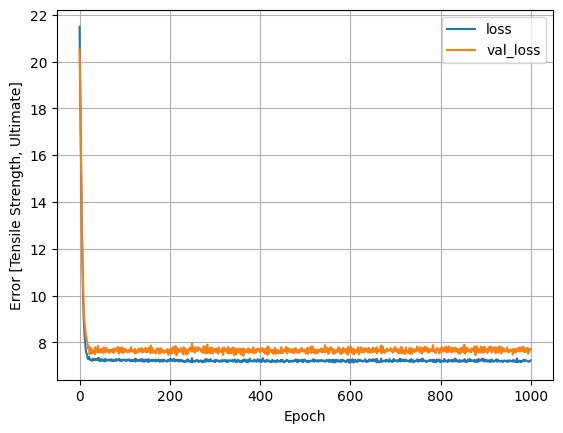

In [ ]:
plot_loss(history)

### Now train a NN model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(25, activation='relu'),
      layers.Dense(25, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(elong_normalizer)
dnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 37)               75        
 ion)                                                            
                                                                 
 dense_29 (Dense)            (None, 25)                950       
                                                                 
 dense_30 (Dense)            (None, 25)                650       
                                                                 
 dense_31 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,626
Non-trainable params: 75
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    elong_train_features,
    elong_train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: total: 45.8 s
Wall time: 27.9 s


In [ ]:
dnn_model.evaluate(elong_test_features, elong_test_labels, verbose=0)

5.556535243988037

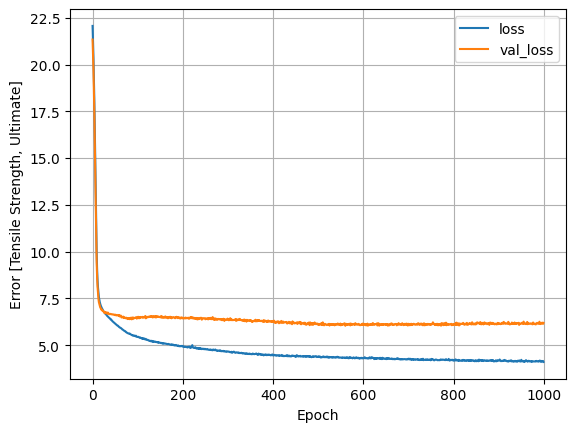

In [ ]:
plot_loss(history)

6/6 [==============================] - 0s 601us/step


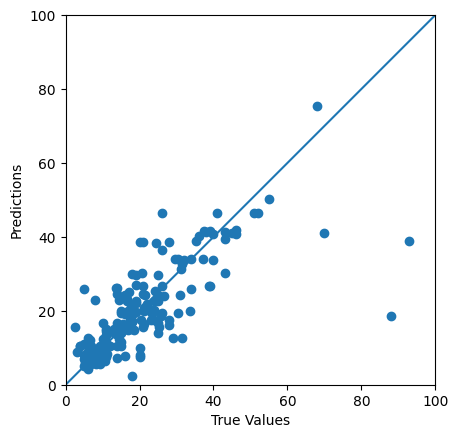

In [ ]:
test_predictions = dnn_model.predict(elong_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(elong_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)